In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series
import os

## Get processed data

In [2]:
df = pd.read_csv('processed_data_shift_5.csv', index_col='DateTime')
df

,Temp,Temp_1,Temp_2,Temp_3,Temp_4,Temp_5,Temp_6,Temp_7,Temp_8,Temp_9,...,Temp_327,Temp_328,Temp_329,Temp_330,Temp_331,Temp_332,Temp_333,Temp_334,Temp_335,Temp_Pred_True
DateTime,,,,,,,,,,,,,,,,,,,,,
1995-01-20 00:00:00,26.067091,26.067384,26.067677,26.067970,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,...,26.162906,26.163199,26.163492,26.163785,26.164078,26.164371,26.164664,26.164957,26.165250,26.200412
1995-01-20 01:00:00,26.067384,26.067677,26.067970,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,26.070021,...,26.163199,26.163492,26.163785,26.164078,26.164371,26.164664,26.164957,26.165250,26.165543,26.200705
1995-01-20 02:00:00,26.067677,26.067970,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,26.070021,26.070314,...,26.163492,26.163785,26.164078,26.164371,26.164664,26.164957,26.165250,26.165543,26.165836,26.200998
1995-01-20 03:00:00,26.067970,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,26.070021,26.070314,26.070607,...,26.163785,26.164078,26.164371,26.164664,26.164957,26.165250,26.165543,26.165836,26.166129,26.201291
1995-01-20 04:00:00,26.068263,26.068556,26.068849,26.069142,26.069435,26.069728,26.070021,26.070314,26.070607,26.070900,...,26.164078,26.164371,26.164664,26.164957,26.165250,26.165543,26.165836,26.166129,26.166422,26.201584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 20:00:00,22.500000,21.600000,20.500000,20.200000,19.900000,19.400000,19.300000,19.000000,18.500000,17.800000,...,29.400000,27.800000,26.900000,27.000000,27.000000,26.300000,25.800000,25.600000,25.200000,22.100000
2017-12-31 21:00:00,21.600000,20.500000,20.200000,19.900000,19.400000,19.300000,19.000000,18.500000,17.800000,17.800000,...,27.800000,26.900000,27.000000,27.000000,26.300000,25.800000,25.600000,25.200000,25.300000,21.700000
2017-12-31 22:00:00,20.500000,20.200000,19.900000,19.400000,19.300000,19.000000,18.500000,17.800000,17.800000,18.100000,...,26.900000,27.000000,27.000000,26.300000,25.800000,25.600000,25.200000,25.300000,24.700000,21.200000


## Split dataset into train and test

In [3]:
train_df = df.loc[:'2016-12-31 23:00:00']
test_df = df.loc['2017-01-01 00:00:00':]

In [4]:
train_df.shape[0]+test_df.shape[0]

201169

## Function for model training and evaluations

In [5]:
def eval_and_save(train_df, test_df, month):
    
    # Model creation
    X_train = train_df.values[:, :-1]
    y_train = train_df.values[:, -1]
    
    gbm = LGBMRegressor(n_estimators=1000, random_state=1, n_jobs=100)
    gbm.fit(X_train, y_train)
    
    # Output from model
    X = test_df.values[:, :-1]
    y = test_df.values[:, -1]
    
    pred = gbm.predict(X[:120])
    
    # Saving graphs and dataset
    df2 = test_df[:120].copy()
    dates = df2.index
    df2.insert(337, 'Predicted', pred)
    df2.to_csv(f'{os.getcwd()}\\pilot outputs\\{month}\\{dates[0][:10]}.csv')
    
    for i in range(5):
        x = dates[24*i:24*(i+1)]
        Y_1 = y[24*i:24*(i+1)]
        Y_2 = pred[24*i:24*(i+1)]
        plt.plot(x,Y_1, color='b', label='True')
        plt.plot(x,Y_2, color='y', label='Predicted')
        plt.legend()
        plt.savefig(f'{os.getcwd()}\\pilot outputs\\{month}\\{dates[i*24][:10]}.png')
        plt.clf()

    # Plot 5 day graph
    plot_series(
        pd.DataFrame(y[:120])[0],
        pd.DataFrame(pred)[0],
        labels=['true', 'predicted'], 
        markers=['.', '_']
    )
    

# Model training and evaluations

## January

### 1st to 5th

<Figure size 432x288 with 0 Axes>

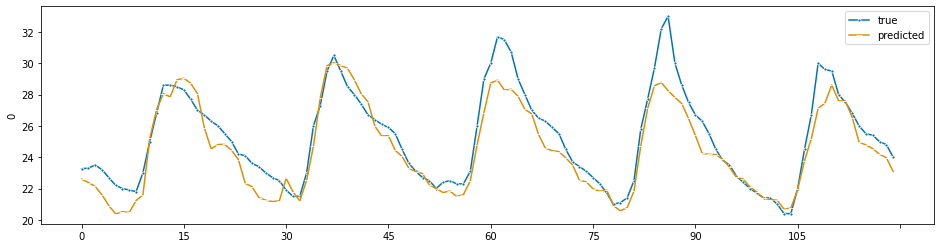

In [6]:
eval_and_save(df.loc[:'2016-12-31 23:00:00'], test_df.loc['2017-01-01 00:00:00' : '2017-01-14 23:00:00'], 'January')

### 15th to 19th

<Figure size 432x288 with 0 Axes>

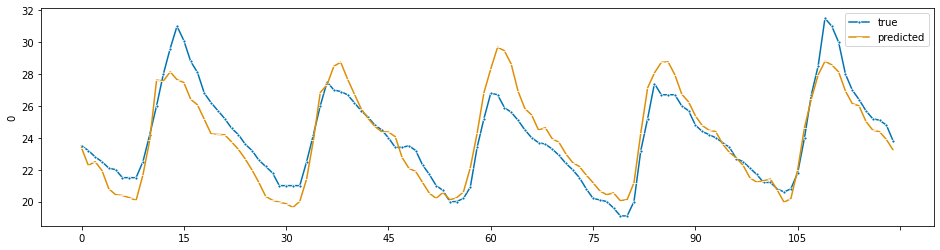

In [7]:
eval_and_save(df.loc[:'2017-01-14 23:00:00'], test_df.loc['2017-01-15 00:00:00' : '2017-01-31 23:00:00'], 'January')

# Feb

### 1st to 5th

<Figure size 432x288 with 0 Axes>

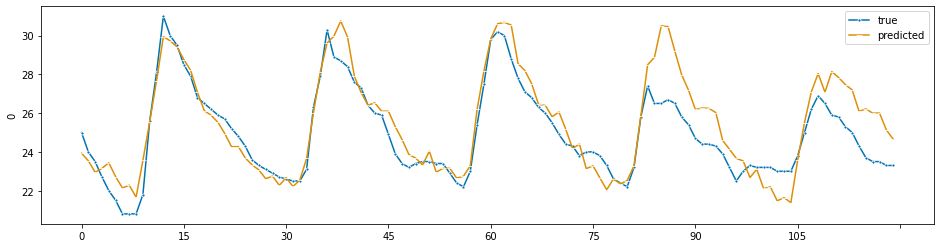

In [8]:
eval_and_save(df.loc[:'2017-01-31 23:00:00'], test_df.loc['2017-02-01 00:00:00' : '2017-02-14 23:00:00'], 'February')

### 15th to 19th

<Figure size 432x288 with 0 Axes>

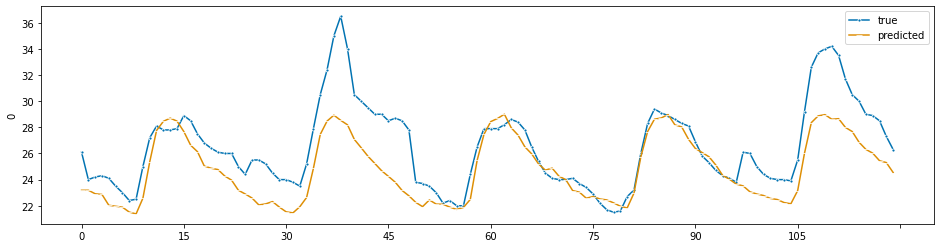

In [9]:
eval_and_save(df.loc[:'2017-02-14 23:00:00'], test_df.loc['2017-02-15 00:00:00' : '2017-02-28 23:00:00'], 'February')

# Mar

### 1st to 5th

<Figure size 432x288 with 0 Axes>

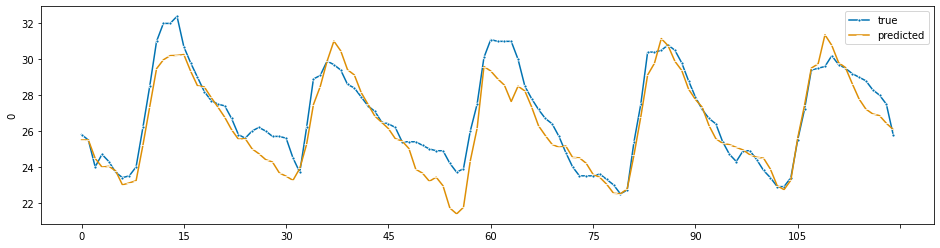

In [10]:
eval_and_save(df.loc[:'2017-02-28 23:00:00'], test_df.loc['2017-03-01 00:00:00' : '2017-03-14 23:00:00'], 'March')

### 15th to 19th

<Figure size 432x288 with 0 Axes>

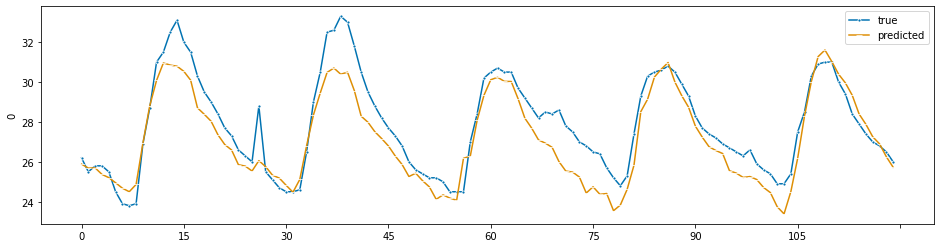

In [11]:
eval_and_save(df.loc[:'2017-03-14 23:00:00'], test_df.loc['2017-03-15 00:00:00' : '2017-03-31 23:00:00'], 'March')

# Apr

### 1st to 5th

<Figure size 432x288 with 0 Axes>

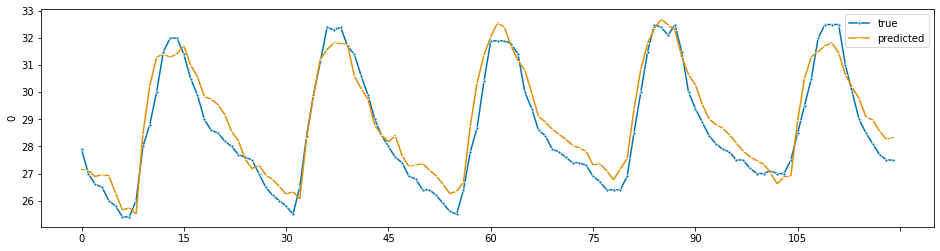

In [12]:
eval_and_save(df.loc[:'2017-03-31 23:00:00'], test_df.loc['2017-04-01 00:00:00' : '2017-04-14 23:00:00'], 'April')

### 15th to 19th

<Figure size 432x288 with 0 Axes>

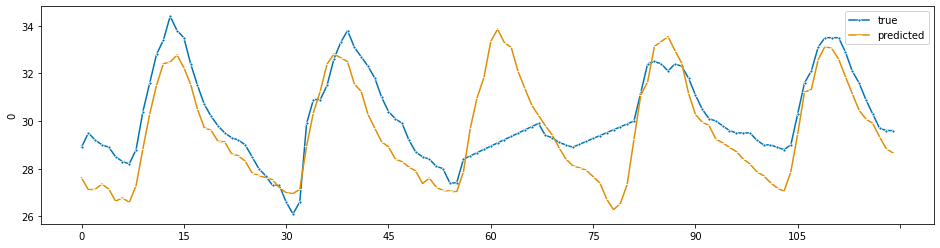

In [13]:
eval_and_save(df.loc[:'2017-04-14 23:00:00'], test_df.loc['2017-04-15 00:00:00' : '2017-04-30 23:00:00'], 'April')

# May

### 1st to 5th

<Figure size 432x288 with 0 Axes>

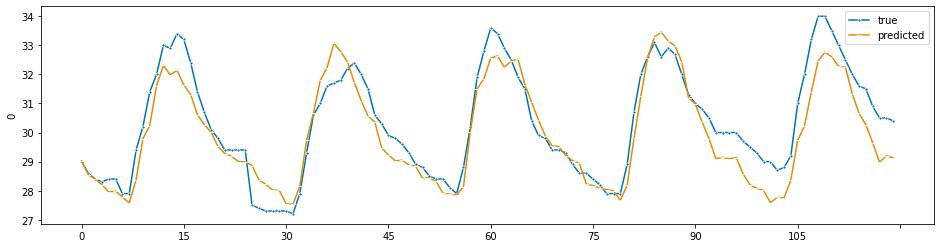

In [14]:
eval_and_save(df.loc[:'2017-04-30 23:00:00'], test_df.loc['2017-05-01 00:00:00' : '2017-05-14 23:00:00'], 'May')

### 15th to 19th

<Figure size 432x288 with 0 Axes>

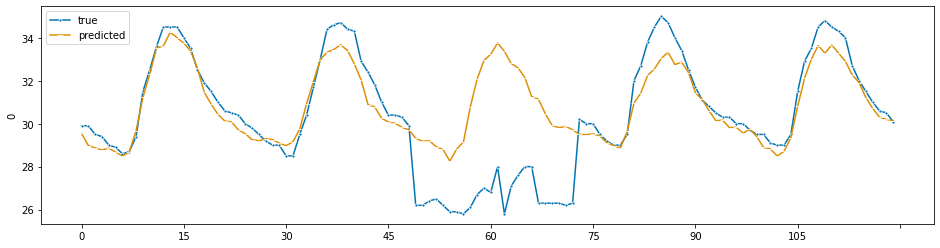

In [15]:
eval_and_save(df.loc[:'2017-05-14 23:00:00'], test_df.loc['2017-05-15 00:00:00' : '2017-05-31 23:00:00'], 'May')

# Jun

### 1st to 5th

<Figure size 432x288 with 0 Axes>

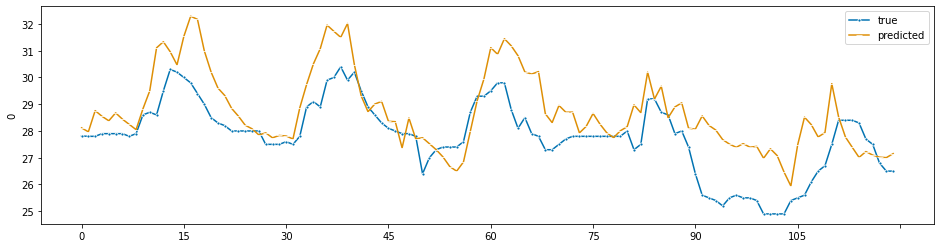

In [16]:
eval_and_save(df.loc[:'2017-05-31 23:00:00'], test_df.loc['2017-06-01 00:00:00' : '2017-06-14 23:00:00'], 'June')

### 15th to 19th

<Figure size 432x288 with 0 Axes>

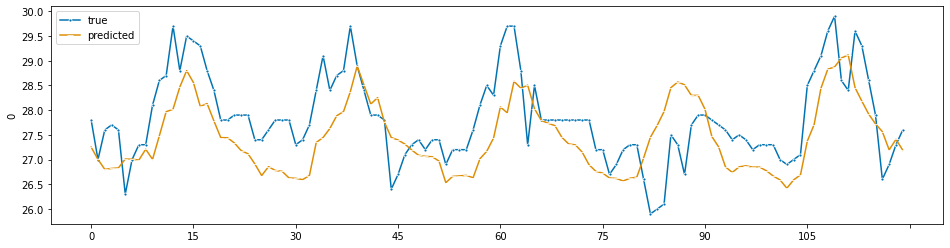

In [17]:
eval_and_save(df.loc[:'2017-06-14 23:00:00'], test_df.loc['2017-06-15 00:00:00' : '2017-06-30 23:00:00'], 'June')

# Jul

### 1st to 5th

<Figure size 432x288 with 0 Axes>

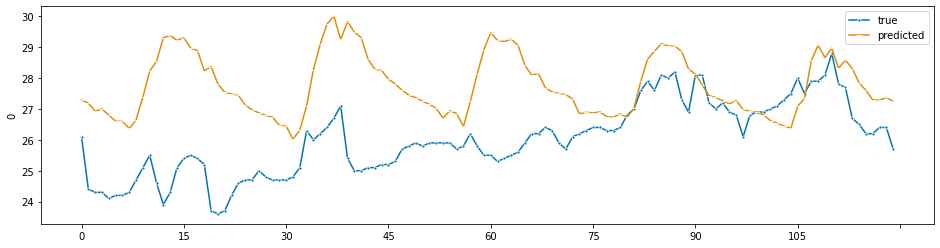

In [18]:
eval_and_save(df.loc[:'2017-06-30 23:00:00'], test_df.loc['2017-07-01 00:00:00' : '2017-07-14 23:00:00'], 'July')

### 15th to 19th

<Figure size 432x288 with 0 Axes>

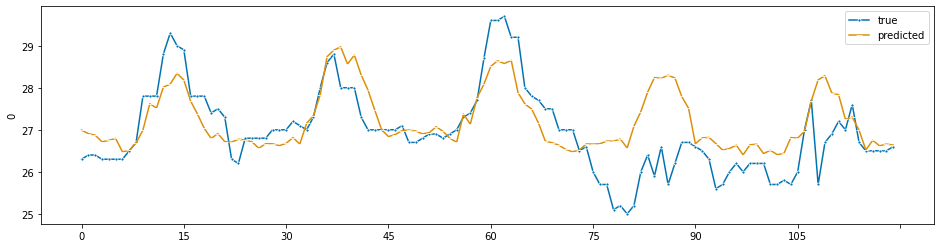

In [19]:
eval_and_save(df.loc[:'2017-07-14 23:00:00'], test_df.loc['2017-07-15 00:00:00' : '2017-07-31 23:00:00'], 'July')

# Aug

### 1st to 5th

<Figure size 432x288 with 0 Axes>

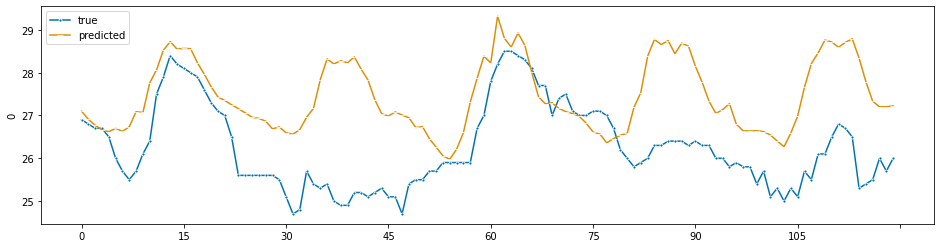

In [20]:
eval_and_save(df.loc[:'2017-07-31 23:00:00'], test_df.loc['2017-08-01 00:00:00' : '2017-08-14 23:00:00'], 'August')

### 15th to 19th

<Figure size 432x288 with 0 Axes>

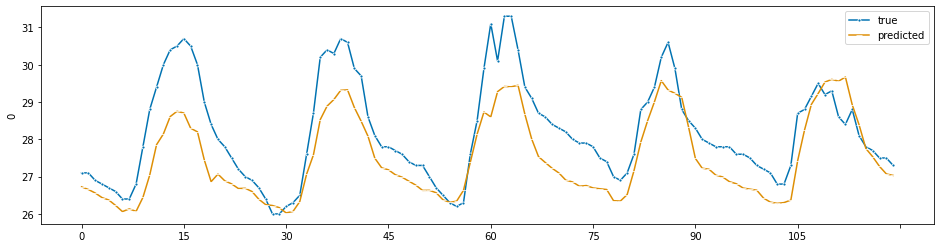

In [21]:
eval_and_save(df.loc[:'2017-08-14 23:00:00'], test_df.loc['2017-08-15 00:00:00' : '2017-08-31 23:00:00'], 'August')

# Sep

### 1st to 5th

<Figure size 432x288 with 0 Axes>

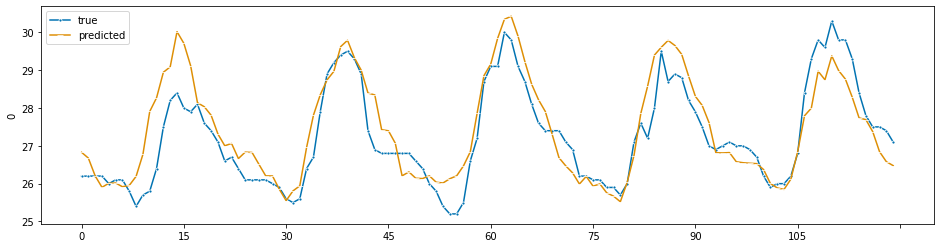

In [22]:
eval_and_save(df.loc[:'2017-08-31 23:00:00'], test_df.loc['2017-09-01 00:00:00' : '2017-09-14 23:00:00'], 'September')

### 15th to 19th

<Figure size 432x288 with 0 Axes>

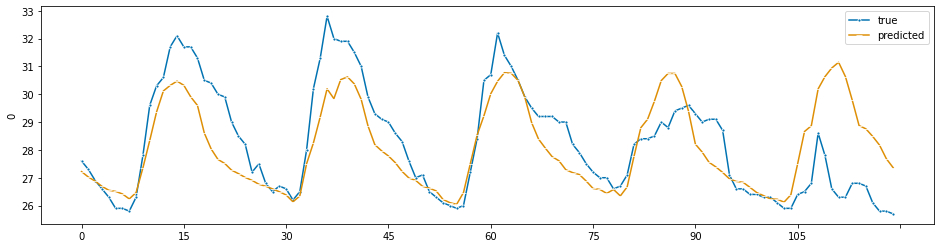

In [23]:
eval_and_save(df.loc[:'2017-09-14 23:00:00'], test_df.loc['2017-09-15 00:00:00' : '2017-09-30 23:00:00'], 'September')

# Oct

### 1st to 5th

<Figure size 432x288 with 0 Axes>

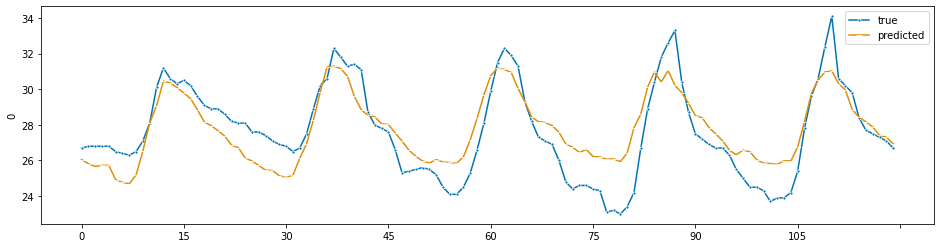

In [24]:
eval_and_save(df.loc[:'2017-09-30 23:00:00'], test_df.loc['2017-10-01 00:00:00' : '2017-10-14 23:00:00'], 'October')

### 15th to 19th

<Figure size 432x288 with 0 Axes>

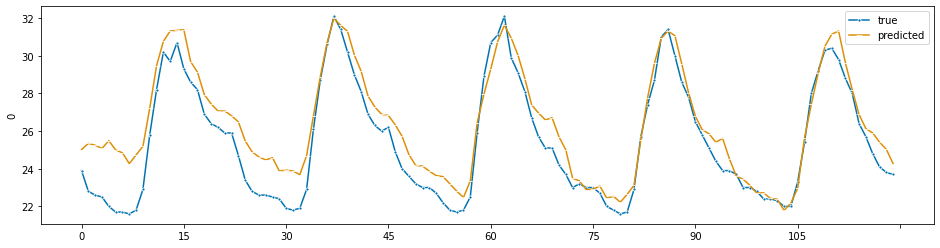

In [25]:
eval_and_save(df.loc[:'2017-10-14 23:00:00'], test_df.loc['2017-10-15 00:00:00' : '2017-10-31 23:00:00'], 'October')

# Nov

### 1st to 5th

<Figure size 432x288 with 0 Axes>

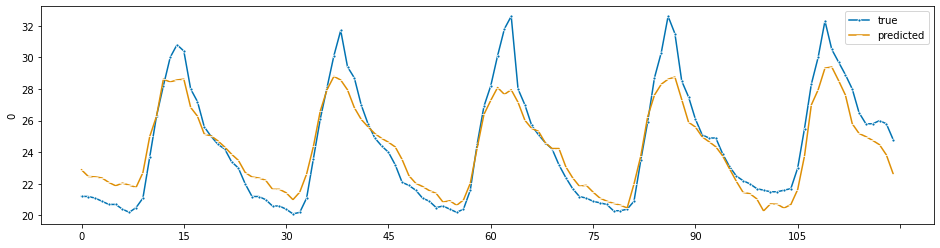

In [26]:
eval_and_save(df.loc[:'2017-10-31 23:00:00'], test_df.loc['2017-11-01 00:00:00' : '2017-11-14 23:00:00'], 'November')

### 15th to 19th

<Figure size 432x288 with 0 Axes>

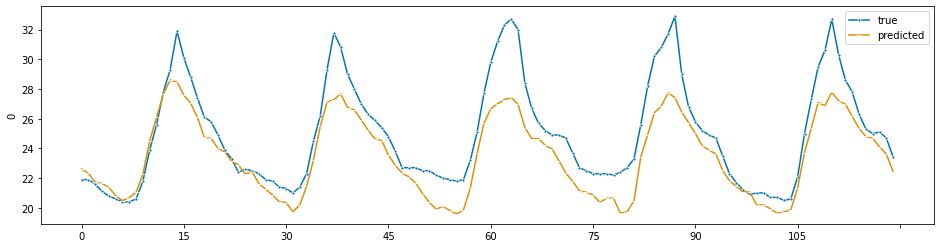

In [27]:
eval_and_save(df.loc[:'2017-11-14 23:00:00'], test_df.loc['2017-11-15 00:00:00' : '2017-11-30 23:00:00'], 'November')

# Dec

### 1st to 5th

<Figure size 432x288 with 0 Axes>

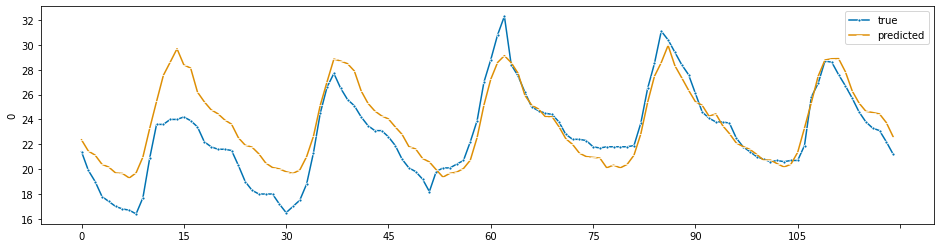

In [28]:
eval_and_save(df.loc[:'2017-11-30 23:00:00'], test_df.loc['2017-12-01 00:00:00' : '2017-12-14 23:00:00'], 'December')

### 15th to 19th

<Figure size 432x288 with 0 Axes>

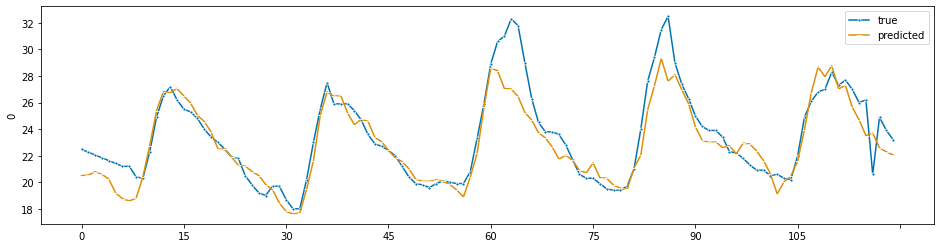

In [29]:
eval_and_save(df.loc[:'2017-12-14 23:00:00'], test_df.loc['2017-12-15 00:00:00' : '2017-12-31 23:00:00'], 'December')